In [1]:
import pandas as pd
import pickle 
import numpy as np
import datetime as dt
### Read the dataFile 
Read = pickle.load( open( "uke_eggedal_data_challenge.pkl", "rb" ) )

#save data on my variable
data  = {}
for ids,sets in Read.items():
    data[ids] = sets

#Check keys and data types in the  dic
for ids,sets in data.items():
    print(ids, f', Dtype = {type(sets)}, Total values in Set:{len(sets)}')
    
#Separate the obs_tas and obs_pr arrays into individual columns to make things easier to see
Temp = {}
precipitation ={}

#create dummy data for dictionary depending on lenght of values 
for i in data['obs_pr']:
    Length = len(i)
    for j in range (Length):
        precipitation[f'Prec_Zone_{j}'] = []
#Fill the empty list with the corresponding data 
index = 0
for ids,val in precipitation.items():
    for i in data['obs_pr']:
        precipitation[ids].insert(index,i[index])
    index = index+1    
dfprecipitation = pd.DataFrame(precipitation)

# Repeat for Temperature

#create dummy data for dictionary depending on lenght of values 
for i in data['obs_tas']:
    Length = len(i)
    for j in range (Length):
        Temp[f'Temp_Zone_{j}'] = []
#Fill the empty list with the corresponding data 
index = 0
for ids,val in Temp.items():
    for i in data['obs_tas']:
        Temp[ids].insert(index,i[index])
    index = index+1  
dfTemp = pd.DataFrame(Temp)
#add the date to each DF 
dfTemp['Date'] = data['obs_dates'].reset_index(drop=True) # Reset Index to keep same index as initial DF
dfTemp['Date'] = pd.to_datetime(dfTemp['Date'])
dfprecipitation['Date'] = data['obs_dates'].reset_index(drop=True) # Reset Index to keep same index as initial DF
dfprecipitation['Date'] = pd.to_datetime(dfprecipitation['Date'])
# Create new DataFrame for all data together
DfTemp_Prec = dfprecipitation.merge(dfTemp, how='inner', on='Date')

#Create DataFrame for de Flow data
dfFlow = pd.DataFrame(data['flow'],columns = ['Flow'])
dfFlow['Date'] = data['flow_dates'].reset_index(drop=True)
#Now we merge the two datasets where the dates are the same 
Df_Final= DfTemp_Prec.merge(dfFlow, how='inner', on='Date')
Df_Final['Flow'] = Df_Final['Flow'].shift(-4)
Df_Final = Df_Final[:-4]

flow , Dtype = <class 'numpy.ndarray'>, Total values in Set:21542
obs_tas , Dtype = <class 'numpy.ndarray'>, Total values in Set:21546
flow_dates , Dtype = <class 'pandas.core.series.Series'>, Total values in Set:21542
obs_lon_lat , Dtype = <class 'list'>, Total values in Set:2
obs_pr , Dtype = <class 'numpy.ndarray'>, Total values in Set:21546
obs_dates , Dtype = <class 'pandas.core.series.Series'>, Total values in Set:21546


In [2]:
# import random
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# import statsmodels.api as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from sklearn.metrics import r2_score
# import warnings
# warnings.filterwarnings('ignore')

# R2 = 0
# number = 0
# while R2 < .30:
#     number = number+1

#     start_date = random.choice(range(1960, 1999))
#     end_date = random.choice(range(2005, 2015))
    
#     working_Df = Df_Final[(Df_Final['Date'] >= f'{start_date}-01-01') & (Df_Final['Date'] < f'{end_date}-01-01')]

#     working_Df['Month'] = pd.DatetimeIndex(working_Df['Date']).month
#     working_Df.drop(['Date'], axis = 1, inplace = True)    
#     #now we import sklearn
#     #we will split the data 80% for training and the other 20% is for test
#     np.random.seed(0)
#     Train, Test = train_test_split(working_Df, train_size = 0.8, test_size = 0.2, random_state = 100)
#     #scaler to bring al variables to similar values
#     scaler = MinMaxScaler()
#     Train[Train.columns] = scaler.fit_transform(Train[Train.columns])
#     y_train = Train.pop('Flow')
#     x_train = Train
    
#     VarList = list(x_train.columns)
#     pickRandom =  random.choice(range(2,len(VarList)))
#     ListToDelete = random.choices(VarList, k=pickRandom)
    
#     X = x_train.drop(ListToDelete,axis = 1)
#     x_train_lm = sm.add_constant(X)
#     Reg = sm.OLS(y_train, x_train_lm).fit()

#     VIF = pd.DataFrame()
#     VIF['Var'] = x_train.columns
#     VIF['VIF'] = [variance_inflation_factor(x_train.values,i)for i in range(x_train.shape[1])]
#     VIF = VIF.sort_values(by='VIF',ascending = False)
    
#     Test[Test.columns] = scaler.fit_transform(Test[Test.columns])
#     y_test = Test.pop('Flow')
#     x_test = Test

#     X_TEST = sm.add_constant(x_test)
#     X_TEST = X_TEST.drop(ListToDelete, axis = 1)
#     Y_PRED = Reg.predict(X_TEST)

#     R2 = r2_score(y_true = y_test, y_pred = Y_PRED)    
#     print(R2)

In [3]:
import pandas
import matplotlib.pyplot as plt
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

numpy.random.seed(7)



In [4]:
working_Df = Df_Final[(Df_Final['Date'] >= f'1960-01-01') & (Df_Final['Date'] < f'2015-01-01')]
# working_Df['Month'] = pd.DatetimeIndex(working_Df['Date']).month
# working_Df.drop(['Date'], axis = 1, inplace = True)
dataset = pd.DataFrame(columns=['Flow'])
dataset['Flow'] = working_Df['Flow']
dataset = dataset.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [8]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
13455/13455 - 9s - loss: 7.5930e-04
Epoch 2/30
13455/13455 - 10s - loss: 4.7378e-04
Epoch 3/30
13455/13455 - 9s - loss: 4.7110e-04
Epoch 4/30
13455/13455 - 9s - loss: 4.7677e-04
Epoch 5/30
13455/13455 - 10s - loss: 4.6924e-04
Epoch 6/30
13455/13455 - 9s - loss: 4.7642e-04
Epoch 7/30
13455/13455 - 9s - loss: 4.6822e-04
Epoch 8/30
13455/13455 - 9s - loss: 4.7034e-04
Epoch 9/30
13455/13455 - 9s - loss: 4.7055e-04
Epoch 10/30
13455/13455 - 10s - loss: 4.6711e-04
Epoch 11/30
13455/13455 - 10s - loss: 4.6682e-04
Epoch 12/30
13455/13455 - 11s - loss: 4.6944e-04
Epoch 13/30
13455/13455 - 10s - loss: 4.6751e-04
Epoch 14/30
13455/13455 - 10s - loss: 4.6785e-04
Epoch 15/30
13455/13455 - 10s - loss: 4.6872e-04
Epoch 16/30
13455/13455 - 10s - loss: 4.6672e-04
Epoch 17/30
13455/13455 - 10s - loss: 4.6884e-04
Epoch 18/30
13455/13455 - 10s - loss: 4.6447e-04
Epoch 19/30
13455/13455 - 10s - loss: 4.6516e-04
Epoch 20/30
13455/13455 - 10s - loss: 4.6349e-04
Epoch 21/30
13455/13455 - 9s - loss:

In [10]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.81 RMSE
Test Score: 1.94 RMSE


In [11]:
#plt.rcParams['figure.dpi'] = 200
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict



In [12]:
len(numpy.empty_like(dataset))

20086

In [13]:
trainPredictPlot = trainPredictPlot[~numpy.isnan(trainPredictPlot)]
testPredictPlot = testPredictPlot[~numpy.isnan(testPredictPlot)]

In [14]:
trainIdx = numpy.arange(0, len(trainPredictPlot), 1, dtype = int)

testIdx = numpy.arange(len(trainPredictPlot)+1, len(trainPredictPlot) +len(testPredictPlot) , 1, dtype = int)

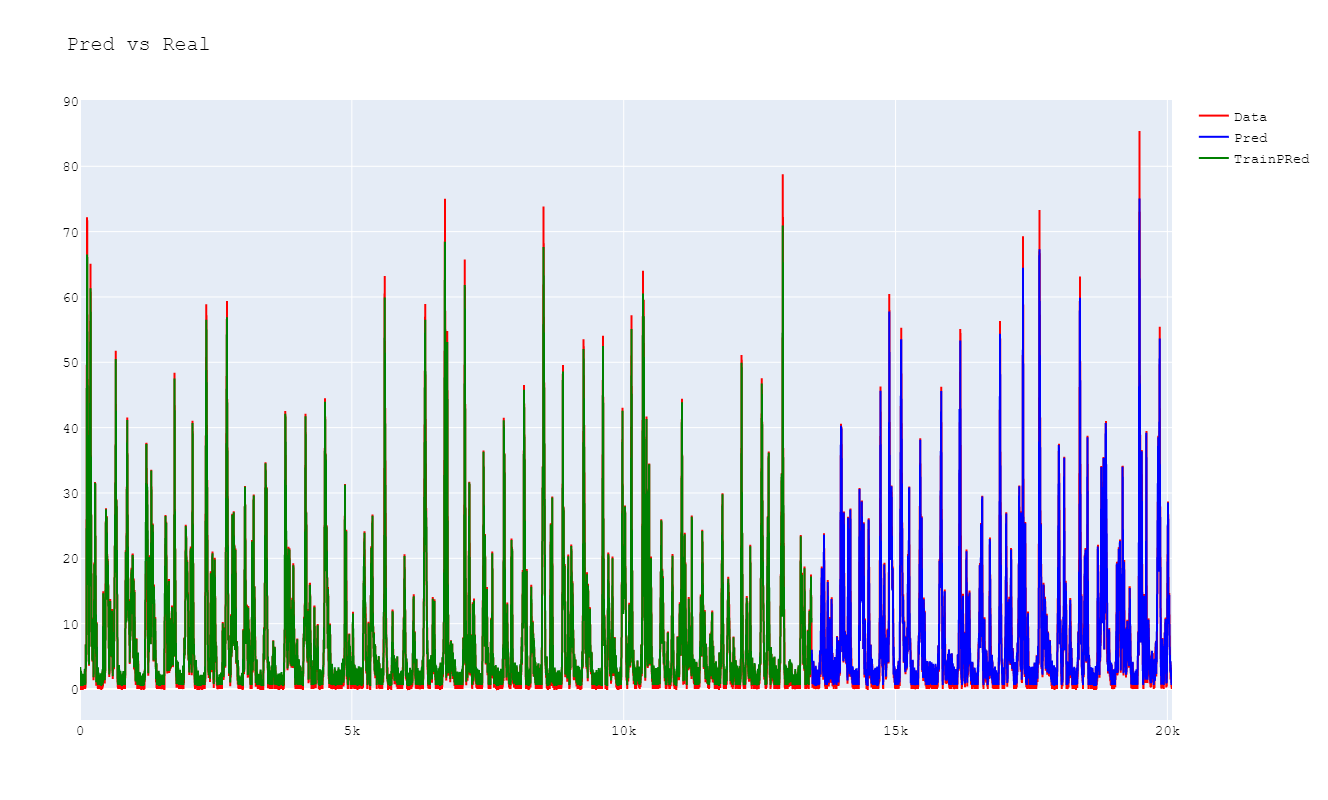

In [15]:
import plotly.offline as pyo
import plotly.graph_objs as go
from IPython.display import display, Markdown, Latex


ColumnsNames = list(dfTemp.columns)
ColumnsNames.remove('Date')
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=(scaler.inverse_transform(dataset)[~numpy.isnan(scaler.inverse_transform(dataset))]),
    name =  f'Data',
    mode = 'lines',
    line = dict(color = 'red'),
    connectgaps=False
    ),
 )

fig.add_trace(go.Scatter(
    y=(testPredictPlot[~numpy.isnan(testPredictPlot)]),
    x = testIdx,
    name =  f'Pred',
    mode = 'lines',
    line = dict(color = 'Blue'),
    connectgaps=False
    ),
 )


fig.add_trace(go.Scatter(
    y=(trainPredictPlot[~numpy.isnan(trainPredictPlot)]),
    x = trainIdx,
    name =  f'TrainPRed',
    mode = 'lines',
    line = dict(color = 'Green'),
    connectgaps=False
    ),
 )


fig.update_layout(
title=f'Pred vs Real',
font=dict(
family="Courier New, monospace",
size=14,
color="#000000"
))
    
fig.update_layout(height=800, width = 1100)

In [16]:
#FinalTest = Df_Final[(Df_Final['Date'] >= f'2015-01-02')]
Original= DfTemp_Prec.merge(dfFlow, how='inner', on='Date')
Original = Original[(Original['Date'] >= f'2015-01-02')]

In [17]:
XFinal = pd.DataFrame(columns=['Flow'])
XFinal['Flow'] = Original['Flow'][:20]
XFinal = scaler.fit_transform(XFinal)

In [22]:
FinalX, FinalY = create_dataset(XFinal, look_back)
FinalX = numpy.reshape(FinalX, (FinalX.shape[0], 1, FinalX.shape[1]))

IndexError: tuple index out of range

In [21]:
# FinalX = [[1.522931],[0.364669],[2.190361],[2.729620],[1.018141],[2.727857],[1.709606],[0.107957]]
# FinalX = np.array(FinalX)
# make predictions
FinalPredict = model.predict(FinalY)
# invert predictions
trainPredict = scaler.inverse_transform(FinalPredict)

In [ ]:
Original['Flow'][15:]